FCPGtools v2 Demonstration Notebook
===============================

The Flow-Conditioned Parameter Grid (FCPG) Tools library (`fcpgtools`) was substantially modernized from versions 1 to 2 to:
- Refactor the code to Objectied Oriented Programming (OOP) structures.
- Adhere to modern Pytyhon Style Guides (https://pep8.org and https://google.github.io/styleguide/).
- Enhance and automate code documentation with docstrings and type hints [PEP 484](https://peps.python.org/pep-0484/).
- Publish to the [Python Packace Index (PyPI)](https://pypi.org/project/fcpgtools/) for easier installation.

In addition to maintaining all functionality of the the original proceedural programming library, the refactor FCPGtools v2 also aimed to:
- Abstract terrain analysis functions to support several different terrain analysis engine dependencies beyond [TauDEM](https://github.com/dtarb/TauDEM), starting with [pysheds](https://github.com/mdbartos/pysheds).
- Improve overall performance and ease of use, which we achieved by using [xarray](https://xarray.dev) data objects for in-memory representation of rasters rather than saving to storage at each computational step.

This notebook is designed to demonstrate those capabilities while also demonstrating potential workflows for endusers.

# Installation and Setup

Carefully follow our **[Installation Instructions](README.md#installation)**.

## Import Python Dependencies

In [1]:
# Python Standard Library
from pathlib import Path
from importlib import reload

# Numerical & Geospatial libraries
import numpy as np
import xarray as xr
import geopandas as gpd

# For examples
import pydaymet

In [2]:
# This library
import fcpgtools

In [69]:
from fcpgtools import utilities

## Set Paths to Input and Output Files with `pathlib`

Use the [pathlib](https://docs.python.org/3/library/pathlib.html) library (built-in to Python 3) to manage paths indpendentely of OS or environment.

This blog post describes `pathlib`'s benefits relative to using the `os` library or string approaches.
- https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f

In [3]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/xrnogueira/Documents/FCPGtools/examples')

In [4]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent
project_path

WindowsPath('C:/Users/xrnogueira/Documents/FCPGtools')

In [5]:
# Set path to example data inputs
data_path = project_path / 'examples/data'
data_path.exists()

True

In [6]:

# Create path for temporary data output files
data_out_path = project_path / 'examples/temp'

if not data_out_path.exists(): 
    data_out_path.mkdir()

data_out_path.exists()

True

# Import Data
**Local files:**
* `us_fdr`: upstream basin Flow Direction Raster (ESRI format).
* `ds_fdr`: downstream basin Flow Direction Raster (ESRI format).
* `daymet_single`: a annual averaged DAYMET precipitation raster.
* `landcover`: a NALCMS 2015 land cover categorical raster.
* `basins_shp`: a shapefile where each row corresponds to a HUC12 level basin.

**Remote files:**
* `daymet_multi`: a 2021 monthly averaged DAYMET precipitation raster accessed via `pydaymet`.

## Pull in local test data

### Get local raster files as `xr.DataArray`s 
**Note:** While seemingly redundant, using `pathlib.Path` objects improves application security, especially if deployed on a remote server. This is because string paths are passed into TauDEM command line calls, which opens a vunerability to custom strings that could control a server remotely. Assuring that all inputs are valid paths (therefore not arbitrary malicious strings), protects against this.

In [7]:
# get tif data paths
us_fdr_tif = data_path /'validation_upstream_fdr.tif'
ds_fdr_tif = data_path / 'validation_downstream_fdr.tif'
landcover_tif = data_path / 'NALCMS_2015.tif'
daymet_tif = data_path / 'validation_daymet_an_P_2017.tif'

# get upstream basin shapefile path
us_basin_shp_path = data_path / 'upstream_wbd.shp'

In [8]:
us_fdr = fcpgtools.load_raster(us_fdr_tif)
ds_fdr = fcpgtools.load_raster(ds_fdr_tif)
landcover = fcpgtools.load_raster(landcover_tif)
daymet_single = fcpgtools.load_raster(daymet_tif)

### Get the basin shapefiles as `geopandas.GeoDataFrame` objects

In [9]:
us_basin_shp = fcpgtools.load_shapefile(us_basin_shp_path)
us_basin_shp

OBJECTID                                   TNMID  \
0      2685  {AAAE4745-7F69-4249-9EE6-61A0FDD375D2}   
1      2737  {6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB}   

                               MetaSource SourceData SourceOrig SourceFeat  \
0  {2E2678AC-0C9D-49CB-806B-540A9302D247}       None       None       None   
1  {AEC557FF-82D8-4F4D-BF0D-2BF431714390}       None       None       None   

     LoadDate  NonContrib  NonContr_1  AreaSqKm  ...  GNIS_ID  \
0  2013-01-18         0.0         0.0    133.04  ...        0   
1  2017-10-25         0.0         0.0     90.55  ...        0   

                        Name States         HUC12 HUType HUMod         ToHUC  \
0  Honey Draw-Colorado River     AZ  140700061105      S    DM  150100010303   
1  Johnson Point-Paria River  AZ,UT  140700070706      S    NM  150100010303   

  Shape_Leng  Shape_Area                                           geometry  
0   0.805006    0.013444  POLYGON ((-111.45208 36.90750, -111.45209 36.9...  
1   0.612730    0.009157  POLYGON ((-111.69386 37.00586, -111.69386 37.0...  

[2 rows x 21 columns]

In [10]:
us_basin_shp.columns

Index(['OBJECTID', 'TNMID', 'MetaSource', 'SourceData', 'SourceOrig',
       'SourceFeat', 'LoadDate', 'NonContrib', 'NonContr_1', 'AreaSqKm',
       'AreaAcres', 'GNIS_ID', 'Name', 'States', 'HUC12', 'HUType', 'HUMod',
       'ToHUC', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

## Import a 12 month DAYMET precipitation raster from `pydaymet` using our AOI
**Note:** Here we use [`pydaymet`](https://hyriver.readthedocs.io/en/latest/autoapi/pydaymet/pydaymet/index.html) to read Daymet data directly into a `xr.DataSet`. We then query only for precipitation (`variable='prcp')` to get a `xr.DataArray`.

In [11]:
us_basin_shp.crs

<Geographic 2D CRS: GEOGCS["GCS_North_American_1983",DATUM["D_North_Am ...>
Name: NAD83
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
fcpgtools.reproject_raster(daymet_single, us_basin_shp)

<xarray.DataArray (y: 30, x: 37)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)
Coordinates:
  * x            (x) float64 -111.8 -111.8 -111.8 ... -111.4 -111.4 -111.4
  * y            (y) float64 37.05 37.03 37.02 37.01 ... 36.76 36.75 36.74 36.73
    band         int32 1
    spatial_ref  int32 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1272.332104144987
    STATISTICS_MAXIMUM:      265
    STATISTICS_MEAN:         170.58792924037
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       35.669764565315
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -999.0

In [13]:
bounding_box = list(fcpgtools.reproject_raster(daymet_single, us_basin_shp).rio.bounds())
bounding_box

[-111.78588315084252,
 36.72363635079582,
 -111.38205939972336,
 37.05106101386543]

In [14]:
%%time
daymet_multi = pydaymet.get_bygeom(bounding_box,
    crs=us_basin_shp.crs.to_wkt(),
    dates=("2021-01-01", "2021-12-30"),
    variables='prcp',
    time_scale="monthly",
    )['prcp']
daymet_multi

CPU times: total: 406 ms
Wall time: 956 ms


<xarray.DataArray 'prcp' (time: 12, y: 39, x: 39)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -508.0 -509.0 -510.0 ... -545.0 -546.0
  * x                        (x) float32 -1.006e+03 -1.005e+03 ... -969.2 -968.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

Upstream FDR (currenly ESRI format)


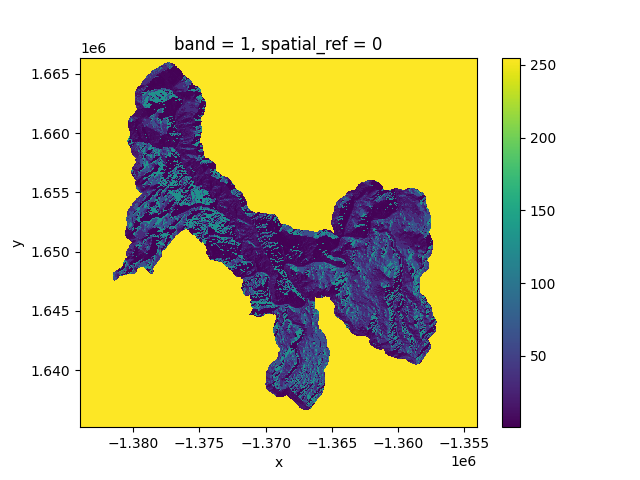

In [15]:
%matplotlib widget
print('Upstream FDR (currenly ESRI format)')
us_fdr.plot()

# Prep Parameter Grids

## Resample/reproject/clip Daymet data

In [16]:
us_fdr_crs = us_fdr.rio.crs
us_fdr_crs

CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North American Datum 1983",SPHEROID["GRS 1980",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [17]:
%%time
print('Aligning single band daymet data to us_fdr:')
aligned_daymet_single = fcpgtools.align_raster(
    daymet_single,
    us_fdr,
    resample_method='bilinear',
    )

Aligning single band daymet data to us_fdr:
CPU times: total: 281 ms
Wall time: 299 ms


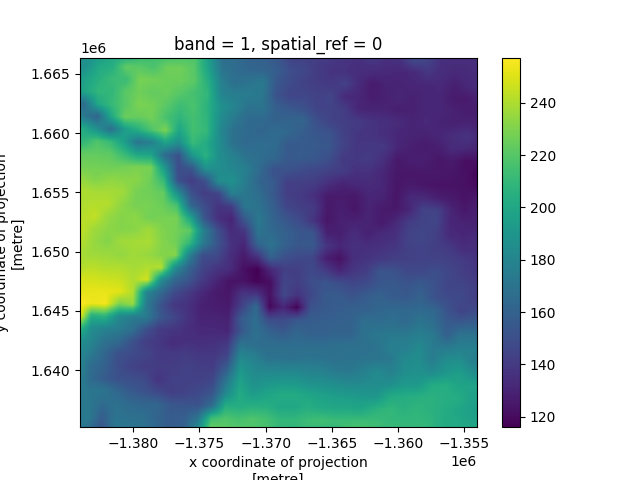

In [18]:
%matplotlib widget
aligned_daymet_single.plot()

Aligning multi-band daymet data to us_fdr (plotting march):


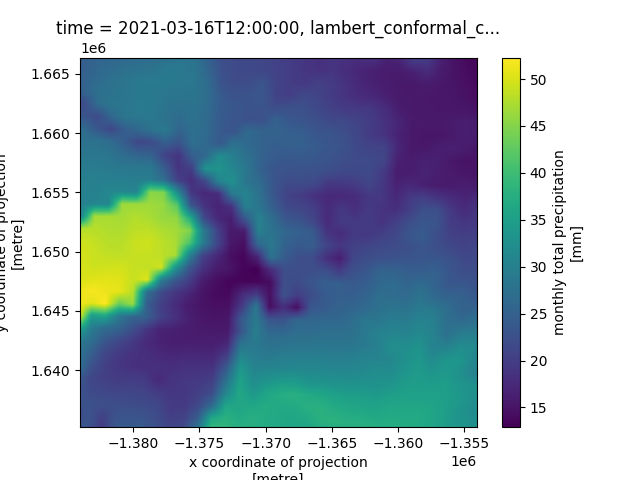

In [19]:
%matplotlib widget
print('Aligning multi-band daymet data to us_fdr (plotting march):')
aligned_daymet_multi = fcpgtools.align_raster(
    daymet_multi,
    us_fdr,
    resample_method='bilinear',
    )
aligned_daymet_multi.isel(time=2).plot()

## Align and Binarize Land Cover

In [20]:
# make a dictionary to improve land cover class labeling
landcover_classes = {
    1: 'evergreen forest',
    7: 'tropical shrubland',
    8: 'temperate shrubland',
    9: 'tropical grassland',
    10: 'temperate grassland',
    14: 'wetland',
    15: 'cropland',
    16: 'barren',
    17: 'urban',
    18: 'open water',
    }

In [21]:
print(f'Landcover class values: {np.unique(landcover.values)}')

Landcover class values: [ 1  7  8  9 10 14 15 16 17 18]


In [22]:
aligned_landcover = fcpgtools.align_raster(
    landcover,
    us_fdr,
    resample_method='nearest',
    )

In [23]:
binary_landcover = fcpgtools.binarize_categorical_raster(
    cat_raster=aligned_landcover,
    categories_dict=landcover_classes,
    ignore_categories=[18],
    )
print(f'binary_landcover band labels: {binary_landcover[binary_landcover.dims[0]].values}')
binary_landcover

binary_landcover band labels: ['evergreen forest' 'tropical shrubland' 'temperate shrubland'
 'tropical grassland' 'temperate grassland' 'wetland' 'cropland' 'barren'
 'urban' 255]


<xarray.DataArray (band: 10, y: 1039, x: 998)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
  * band         (band) object 'evergreen forest' 'tropical shrubland' ... 255
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_MAXIMUM:      18
    STATISTICS_MEAN:         8.6976529407961
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.4539097667876
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              255

In [24]:
binary_landcover.dtype

dtype('uint8')

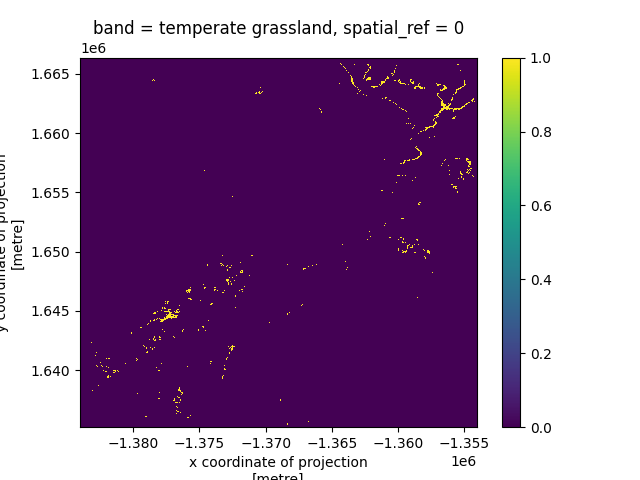

In [25]:
%matplotlib widget
binary_landcover[4].plot()

# Make Upstream Basin Flow Accumulation Cell (FAC) Rasters

## w/ PySheds

In [26]:
%%time
fac_pysheds = fcpgtools.accumulate_flow(
    d8_fdr=us_fdr,
    engine='pysheds',
    upstream_pour_points=None,
    )
display(fac_pysheds)
print(f'PySheds FAC nodata value: {fac_pysheds.rio.nodata}')

<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes: (12/14)
    AREA_OR_POINT:           Area
    DataType:                Generic
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

PySheds FAC nodata value: nan
CPU times: total: 93.8 ms
Wall time: 88.6 ms


In [27]:
print(fac_pysheds.dtype)
fac_pysheds

float64


<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes: (12/14)
    AREA_OR_POINT:           Area
    DataType:                Generic
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

C:\Users\xrnogueira\Miniconda3\envs\fcpgtools_base_test\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


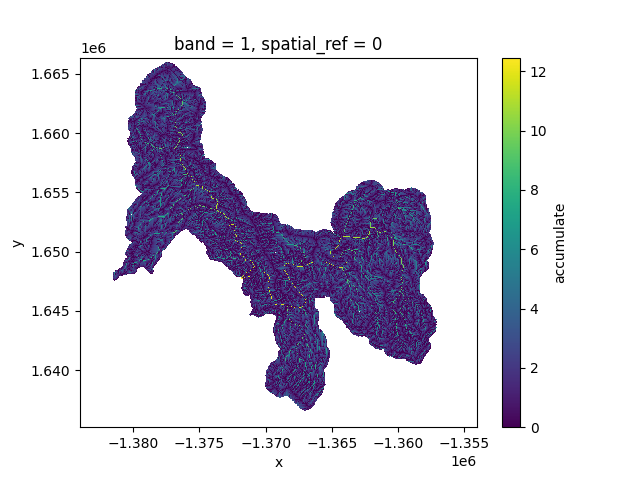

In [28]:
%matplotlib widget
np.log(fac_pysheds).plot()

In [29]:
fac_pysheds

<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes: (12/14)
    AREA_OR_POINT:           Area
    DataType:                Generic
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

## w/ TauDEM

In [30]:
fcpgtools.custom_types.Raster

typing.Union[xarray.core.dataarray.DataArray, str, pathlib.Path]

In [31]:
%%time
fac_taudem = fcpgtools.accumulate_flow(
    d8_fdr=us_fdr,
    engine='taudem',
    upstream_pour_points=None,
    )
print(f'TauDEM FAC nodata value: {fac_taudem.rio.nodata}')

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
TauDEM FAC nodata value: nan
CPU times: total: 344 ms
Wall time: 832 ms


In [32]:
print(fac_taudem.dtype)
fac_taudem

float64


<xarray.DataArray (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

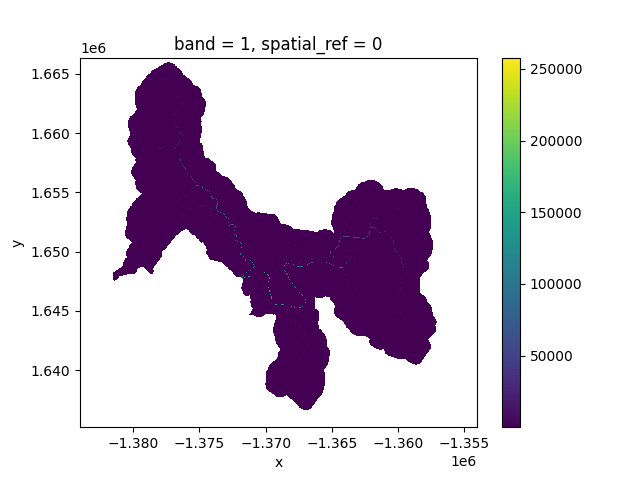

In [33]:
%matplotlib widget
fac_taudem.plot()

# Get HUC basin pour point locations and accumulation values
`tools.get_pour_point_values()` -> `custom_types.PourPointValuesDict`, which has the following form:
```python
# index positions in each dict.values() list corresponds to the basin ID
pour_point_values_dict = {
    'pour_point_ids': ['140700061105', '140700070706'], # each basin ID
    'pour_point_coords': [(-1370609.9, 1648259.9), (-1375289.9, 1653809.9)], # x, y coordinates of each basin's pour point
    'pour_point_values': [[32738.0], [8721.0]] # the value at the pour point -> will have multiple values for a multi-band paramaeter accumulation
}
```

## HUC12 basin

In [34]:
%%time
huc12_pour_points_loc = fcpgtools.find_basin_pour_points(
            fac_pysheds,
            us_basin_shp,
            basin_id_field='HUC12',
            use_huc4=False,
            )

huc12_pour_point_values_dict = fcpgtools.get_pour_point_values(
            huc12_pour_points_loc,
            fac_pysheds,
            )
display(huc12_pour_point_values_dict)

{'pour_point_ids': ['140700061105', '140700070706'],
 'pour_point_coords': [(-1370639.9999999995, 1648259.9999999963),
  (-1371809.9999999995, 1647809.9999999963)],
 'pour_point_values': [[155004.0], [101306.0]]}

CPU times: total: 469 ms
Wall time: 485 ms


## HUC4 basin

In [35]:
%%time
huc4_pour_points_loc = fcpgtools.find_basin_pour_points(
            fac_pysheds,
            us_basin_shp,
            basin_id_field='HUC12',
            use_huc4=True,
            )

huc4_pour_point_values_dict = fcpgtools.get_pour_point_values(
            huc4_pour_points_loc,
            fac_pysheds,
            )
display(huc4_pour_point_values_dict)

Using HUC4 level flow basins, converting from HUC12


{'pour_point_ids': ['1407'],
 'pour_point_coords': [(-1370639.9999999995, 1648259.9999999963)],
 'pour_point_values': [[155004.0]]}

CPU times: total: 234 ms
Wall time: 235 ms


# Make Daymet parameter accumulation grid

## w/ PySheds

### Annual averaged (single-band)

In [36]:
%%time
daymet_single_accum = fcpgtools.accumulate_parameter( 
    d8_fdr=us_fdr,
    parameter_raster=aligned_daymet_single,
    engine='pysheds',
    )
daymet_single_accum

CPU times: total: 188 ms
Wall time: 143 ms


<xarray.DataArray 'accumulate' (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes: (12/14)
    AREA_OR_POINT:           Area
    DataType:                Generic
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

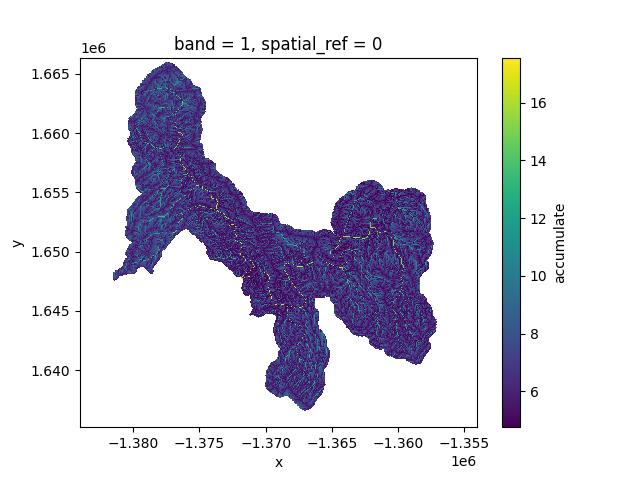

In [37]:
%matplotlib widget
np.log(daymet_single_accum).plot()

### Monthly averaged (multi-band)

In [38]:
%%time
daymet_multi_accum = fcpgtools.accumulate_parameter( 
    d8_fdr=us_fdr,
    parameter_raster=aligned_daymet_multi,
    engine='pysheds',
    )
daymet_multi_accum

CPU times: total: 2.2 s
Wall time: 1.68 s


<xarray.DataArray 'accumulate' (time: 12, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2021-01-16T12:00:00 ... 2021-12-16T12:...
Attributes: (12/14)
    AREA_OR_POINT:           Area
    DataType:                Generic
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

In [39]:
for band in range(len(daymet_multi_accum[daymet_multi_accum.dims[0]])):
    print(f'Mean month={band + 1} accumulation: {daymet_multi_accum[band].mean()}')

Mean month=1 accumulation: <xarray.DataArray 'accumulate' ()>
array(2639.15297265)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-01-16T12:00:00
Mean month=2 accumulation: <xarray.DataArray 'accumulate' ()>
array(2821.25537839)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-02-15
Mean month=3 accumulation: <xarray.DataArray 'accumulate' ()>
array(11260.53861358)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-03-16T12:00:00
Mean month=4 accumulation: <xarray.DataArray 'accumulate' ()>
array(2521.58989444)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-04-16
Mean month=5 accumulation: <xarray.DataArray 'accumulate' ()>
array(0.)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-05-16T12:00:00
Mean month=6 accumulation: <xarray.Dat

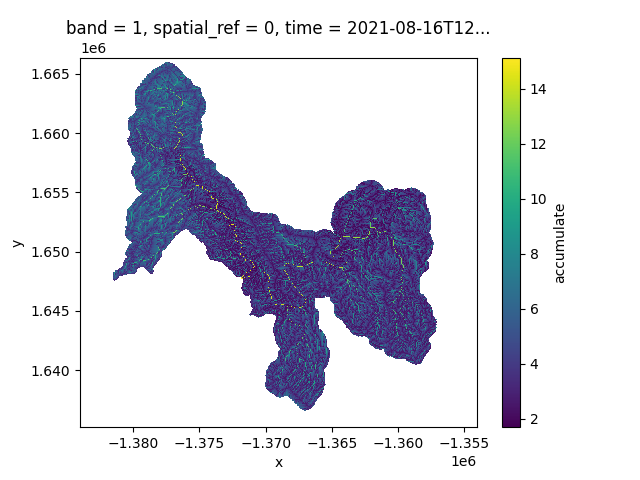

In [40]:
%matplotlib widget
np.log(daymet_multi_accum[7]).plot()

## w/ TauDEM

### Annual averaged (single-band)

In [41]:
%%time
daymet_single_accum_taudem = fcpgtools.accumulate_parameter( 
    d8_fdr=us_fdr,
    parameter_raster=aligned_daymet_single,
    engine='taudem',
    )
daymet_single_accum_taudem

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 469 ms
Wall time: 816 ms


<xarray.DataArray 'accumulate_parameter' (y: 1039, x: 998)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

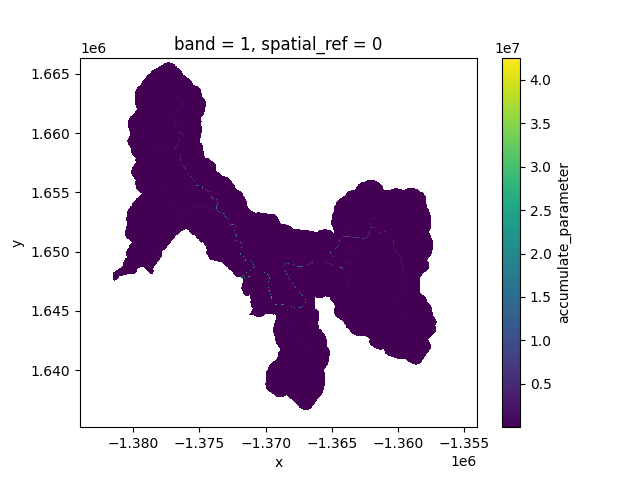

In [42]:
%matplotlib widget
daymet_single_accum_taudem.plot()

### Monthly averaged (multi-band)

In [43]:
%%time
daymet_multi_accum_taudem = fcpgtools.accumulate_parameter( 
    d8_fdr=us_fdr,
    parameter_raster=aligned_daymet_multi,
    engine='taudem',
    )
daymet_multi_accum_taudem

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 3.94 s
Wall time: 8.19 s


<xarray.DataArray 'accumulate_parameter' (time: 12, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    band         int32 1
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2021-01-16T12:00:00 ... 2021-12-16T12:...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

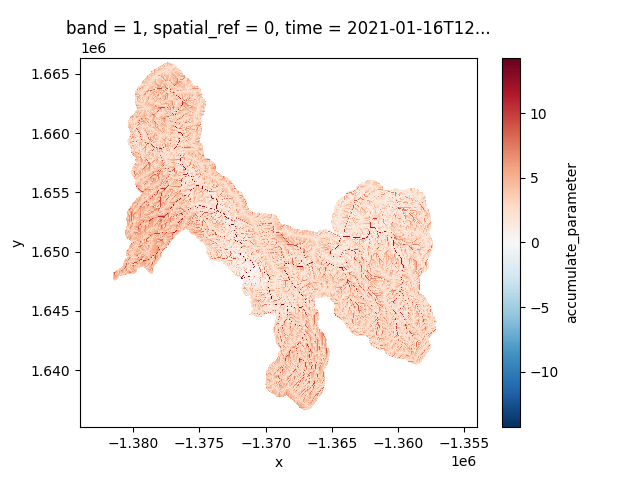

In [44]:
%matplotlib widget
np.log(daymet_multi_accum_taudem[0]).plot()

In [45]:
# note that in the raw data months 5 and 11 are all zeros so should be zero
for band in range(len(daymet_multi_accum_taudem[daymet_multi_accum_taudem.dims[0]])):
    print(f'Mean month={band + 1} accumulation: {daymet_multi_accum_taudem[band].mean()}')

Mean month=1 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(2645.99244901)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-01-16T12:00:00
Mean month=2 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(2828.9382907)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-02-15
Mean month=3 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(11295.77355483)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-03-16T12:00:00
Mean month=4 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(2528.32429612)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-04-16
Mean month=5 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(0.)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-05-1

# Make landcover accumulation raster

## w/ PySheds

In [46]:
%%time
landcover_accum_pysheds = fcpgtools.accumulate_parameter( 
    d8_fdr=us_fdr,
    parameter_raster=binary_landcover,
    engine='pysheds',
    )
landcover_accum_pysheds

CPU times: total: 1.55 s
Wall time: 1.51 s


<xarray.DataArray 'accumulate' (band: 10, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) object 'evergreen forest' 'tropical shrubland' ... 255
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes: (12/14)
    AREA_OR_POINT:           Area
    DataType:                Generic
    BandName:                fdr
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1837.432364428409
    STATISTICS_MAXIMUM:      128
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.865281574118
    _FillValue:              nan
    scale_factor:            1.0
    add_offset:              0.0

C:\Users\xrnogueira\Miniconda3\envs\fcpgtools_base_test\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


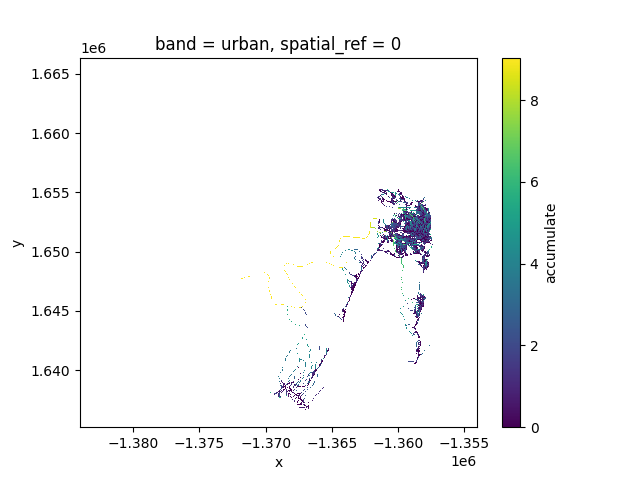

In [47]:
%matplotlib widget
np.log(landcover_accum_pysheds[8]).plot()

In [48]:
for band in list(landcover_accum_pysheds[landcover_accum_pysheds.dims[0]]):
    print(f'Landcover class={band} accumulation: {landcover_accum_pysheds.sel(band=band).mean()}')

Landcover class=<xarray.DataArray 'band' ()>
array('evergreen forest', dtype='<U16')
Coordinates:
    band         <U16 'evergreen forest'
    spatial_ref  int32 0 accumulation: <xarray.DataArray 'accumulate' ()>
array(0.12929587)
Coordinates:
    band         <U16 'evergreen forest'
    spatial_ref  int32 0
Landcover class=<xarray.DataArray 'band' ()>
array('tropical shrubland', dtype='<U18')
Coordinates:
    band         <U18 'tropical shrubland'
    spatial_ref  int32 0 accumulation: <xarray.DataArray 'accumulate' ()>
array(0.)
Coordinates:
    band         <U18 'tropical shrubland'
    spatial_ref  int32 0
Landcover class=<xarray.DataArray 'band' ()>
array('temperate shrubland', dtype='<U19')
Coordinates:
    band         <U19 'temperate shrubland'
    spatial_ref  int32 0 accumulation: <xarray.DataArray 'accumulate' ()>
array(391.70380583)
Coordinates:
    band         <U19 'temperate shrubland'
    spatial_ref  int32 0
Landcover class=<xarray.DataArray 'band' ()>
array('tropical 

## w/ TauDEM

In [49]:
%%time
landcover_accum_taudem = fcpgtools.accumulate_parameter( 
    d8_fdr=us_fdr,
    parameter_raster=binary_landcover,
    engine='taudem',
    )
landcover_accum_taudem

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 3.03 s
Wall time: 7.31 s


<xarray.DataArray 'accumulate_parameter' (band: 10, y: 1039, x: 998)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) object 'evergreen forest' 'tropical shrubland' ... 255
  * x            (x) float64 -1.384e+06 -1.384e+06 ... -1.354e+06 -1.354e+06
  * y            (y) float64 1.666e+06 1.666e+06 ... 1.635e+06 1.635e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [50]:
for band in range(len(landcover_accum_taudem[landcover_accum_taudem.dims[0]])):
    print(f'Mean landcover class={band + 1} accumulation: {landcover_accum_taudem[band].mean()}')

Mean landcover class=1 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(0.12734453)
Coordinates:
    band         <U16 'evergreen forest'
    spatial_ref  int32 0
Mean landcover class=2 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(0.)
Coordinates:
    band         <U18 'tropical shrubland'
    spatial_ref  int32 0
Mean landcover class=3 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(391.50216443)
Coordinates:
    band         <U19 'temperate shrubland'
    spatial_ref  int32 0
Mean landcover class=4 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(0.)
Coordinates:
    band         <U18 'tropical grassland'
    spatial_ref  int32 0
Mean landcover class=5 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(1.35135526)
Coordinates:
    band         <U19 'temperate grassland'
    spatial_ref  int32 0
Mean landcover class=6 accumulation: <xarray.DataArray 'accumulate_parameter' ()>
array(2.21604124)
Coordinat

# Create basic FCPGs

In [51]:
%%time
fcpg = fcpgtools.make_fcpg(daymet_multi_accum_taudem, fac_taudem)

CPU times: total: 62.5 ms
Wall time: 57 ms


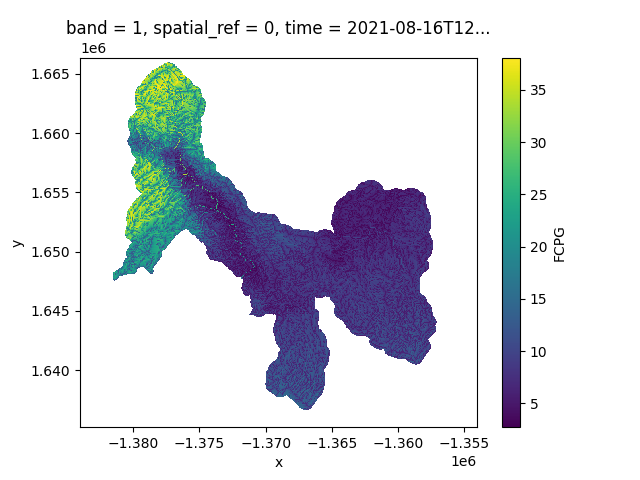

In [52]:
%matplotlib widget
fcpg[7].plot()

In [53]:
# note that in the raw data months 5 and 11 are all zeros so should be zero
for band in range(len(fcpg[fcpg.dims[0]])):
    print(f'Mean month={band + 1} fcpg value: {fcpg[band].mean()}')

Mean month=1 fcpg value: <xarray.DataArray 'FCPG' ()>
array(5.11921138)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-01-16T12:00:00
Mean month=2 fcpg value: <xarray.DataArray 'FCPG' ()>
array(5.13663685)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-02-15
Mean month=3 fcpg value: <xarray.DataArray 'FCPG' ()>
array(20.48922951)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-03-16T12:00:00
Mean month=4 fcpg value: <xarray.DataArray 'FCPG' ()>
array(4.5504521)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-04-16
Mean month=5 fcpg value: <xarray.DataArray 'FCPG' ()>
array(0.)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
    time         datetime64[ns] 2021-05-16T12:00:00
Mean month=6 fcpg value: <xarray.DataArray 'FCPG' ()>
array(2.02870268)
Coordinates:
    ba

# Make extream upslope value raster (TauDEM only)

In [54]:
%%time
ext_upslope_raster = fcpgtools.extreme_upslope_values(
    d8_fdr=us_fdr,
    parameter_raster=aligned_daymet_multi,
    engine='taudem',
    mask_streams=None,
    get_min_upslope=False,
    )

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 2.58 s
Wall time: 6.89 s


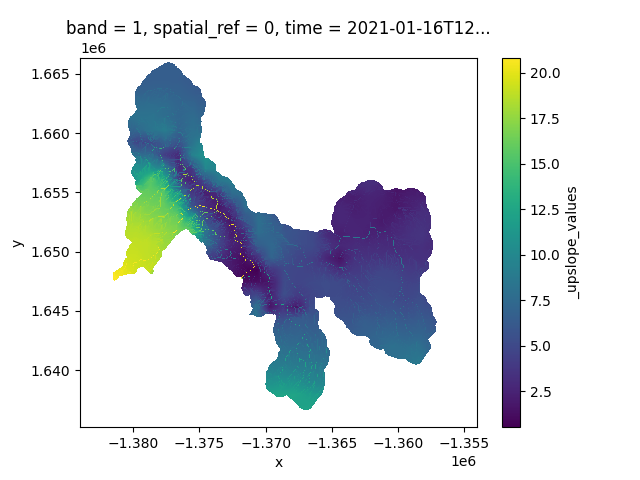

In [55]:
%matplotlib widget
ext_upslope_raster[0].plot()

# Make distance to stream raster (TauDEM only)

In [56]:
dis2stream = fcpgtools.distance_to_stream(
    us_fdr,
    fac_taudem,
    accum_threshold=500,
    engine='taudem',
    )

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem


C:\Users\xrnogueira\Miniconda3\envs\fcpgtools_base_test\lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


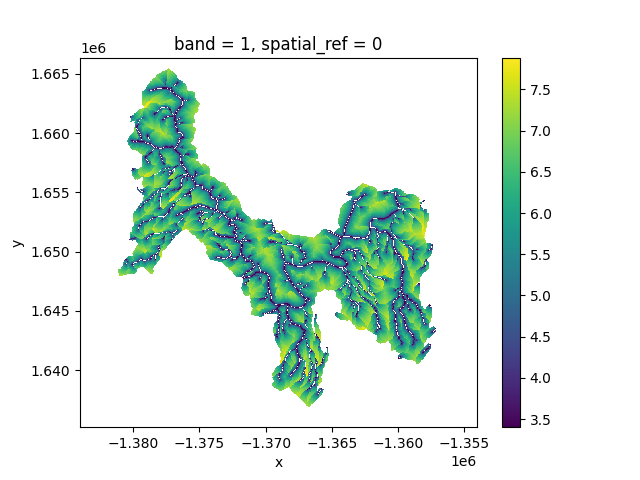

In [57]:
%matplotlib widget
np.log(dis2stream).plot()

# Make a decay accumulation raster (TauDEM only)

## Make decay raster from the distance to stream raster (decay constant = 2)

In [58]:
%%time
decay_raster = fcpgtools.make_decay_raster(
    distance_to_stream_raster=dis2stream,
    decay_factor=2,
    )

CPU times: total: 31.2 ms
Wall time: 25 ms


## Use the decay raster to alter precipitation accumulation (TauDEM only)

In [59]:
%%time
decay_accum = fcpgtools.decay_accumulation(
    us_fdr,
    decay_raster=decay_raster,
    parameter_raster=aligned_daymet_multi,
    engine='taudem',
    )

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 3.34 s
Wall time: 17.2 s


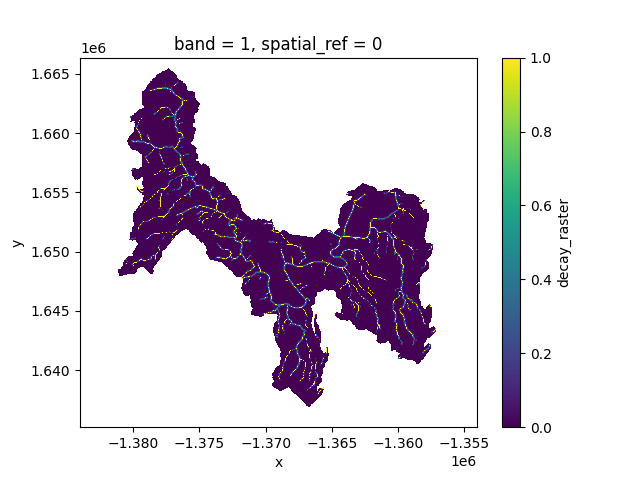

In [60]:
%matplotlib widget
decay_raster.plot()

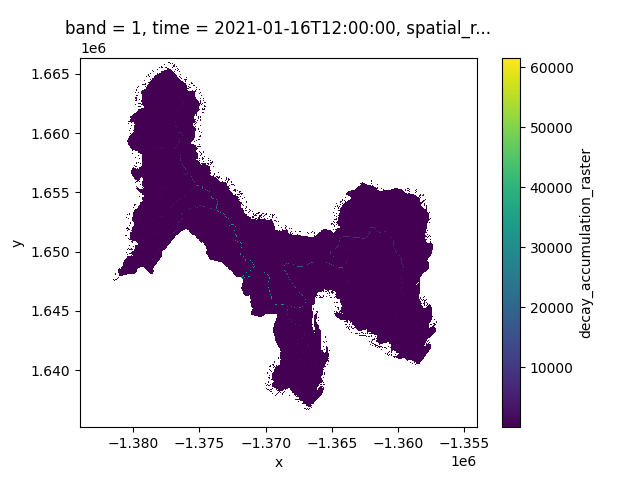

In [61]:
%matplotlib widget
decay_accum[0].plot()

# Demonstration of using pour points to "cascade" accumulation from one basin to another

## Get the full FAC's outpur pour point to cascade to the downstream basin

In [62]:
fac_pour_point = fcpgtools.find_fac_pour_point(
    fac_taudem,
    basin_name='upstream_fac',
    )

In [63]:
fac_pour_point_values = fcpgtools.get_pour_point_values(
    fac_pour_point,
    fac_taudem,
    )
display(fac_pour_point_values)

{'pour_point_ids': ['upstream_fac'],
 'pour_point_coords': [(-1371809.9999999995, 1647749.9999999963)],
 'pour_point_values': [[257922.0]]}

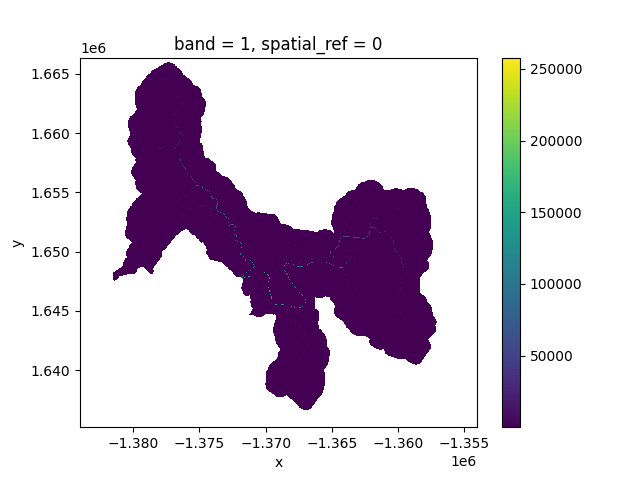

In [64]:
%matplotlib widget
fac_taudem.plot()

## Convert the downstream basin FDR to TauDEM format

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem


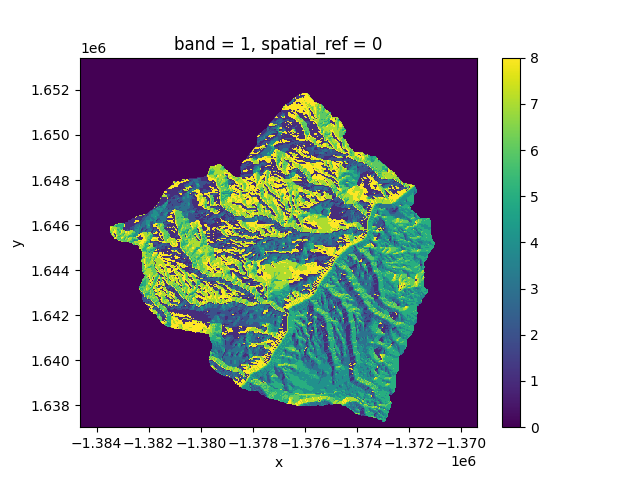

In [65]:
%matplotlib widget
ds_fdr_taudem = fcpgtools.convert_fdr_formats(
    ds_fdr,
    out_format='taudem',
    )
ds_fdr_taudem.plot()

## Cascade upstream accumulation to the downstream basin

In [66]:
%%time
ds_accumulate = fcpgtools.accumulate_flow(
    ds_fdr_taudem,
    engine='taudem',
    upstream_pour_points=fac_pour_point_values,
)

CPU times: total: 344 ms
Wall time: 628 ms


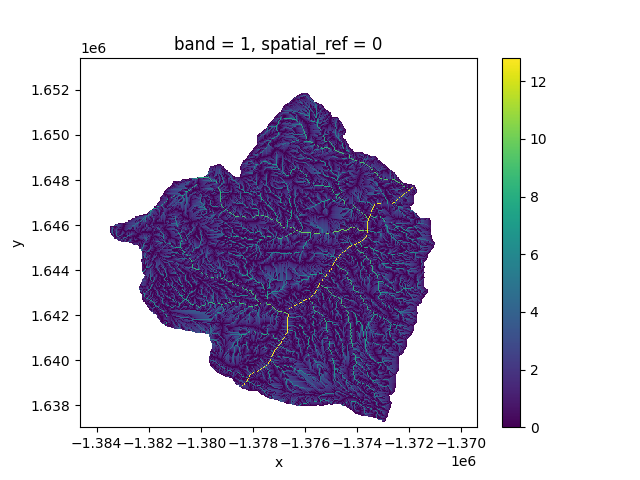

In [67]:
%matplotlib widget
np.log(ds_accumulate).plot()

In [70]:
# test that the pour point is updated
updated_coords = utilities._find_downstream_cell(
    ds_fdr_taudem,
    fac_pour_point_values['pour_point_coords'][0])
us_val = fac_pour_point_values['pour_point_values'][0][0]
print(f'Cascaded amoutn from upstream: {us_val}')
ds_val = utilities._query_point(
    ds_accumulate,
    updated_coords,
    )[-1]
print(f'Value of cell downstream from the upstream pour point: {ds_val}')
print('If the numbers above are not very simular there is likely an issue!')

Cascaded amoutn from upstream: 257922.0
Value of cell downstream from the upstream pour point: 257928.0
If the numbers above are not very simular there is likely an issue!


## Cascade upstream precipitation to the downstream basin
This tests the multi-dimensional cascade functionality.

In [71]:
precip_pour_point_values = fcpgtools.get_pour_point_values(
    fac_pour_point,
    daymet_multi_accum_taudem,
    )
display(precip_pour_point_values)

{'pour_point_ids': ['upstream_fac'],
 'pour_point_coords': [(-1371809.9999999995, 1647749.9999999963)],
 'pour_point_values': [[1601968.25,
   1713891.75,
   6650215.5,
   1551558.625,
   0.0,
   677839.625,
   9266240.0,
   3756741.0,
   4090011.0,
   9710814.0,
   0.0,
   4939786.0]]}

### Pull in downstream precipitation and align with the downstream FDR

In [72]:
ds_bounding_box = list(fcpgtools.reproject_raster(ds_fdr_taudem, us_basin_shp).rio.bounds())
ds_bounding_box

[-111.75476548961305,
 36.745278173879214,
 -111.55403498022008,
 36.91202922400191]

In [73]:
%%time
daymet_multi_ds = pydaymet.get_bygeom(ds_bounding_box,
    crs=us_basin_shp.crs.to_wkt(),
    dates=("2021-01-01", "2021-12-30"),
    variables='prcp',
    time_scale="monthly",
    )['prcp']
daymet_multi_ds

CPU times: total: 703 ms
Wall time: 1.05 s


<xarray.DataArray 'prcp' (time: 12, y: 20, x: 19)>
array([[[       nan,        nan, 12.62     , ...,        nan,
                nan,        nan],
        [       nan,        nan, 12.93     , ...,        nan,
                nan,        nan],
        [       nan,        nan, 18.28     , ...,  6.5      ,
          5.05     ,  4.6400003],
        ...,
        [       nan,  6.9900002,  7.15     , ..., 12.610001 ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 12.68     ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 12.81     ,
                nan,        nan]],

       [[       nan,        nan,  8.01     , ...,        nan,
                nan,        nan],
        [       nan,        nan,  8.15     , ...,        nan,
                nan,        nan],
        [       nan,        nan,  8.28     , ...,  6.52     ,
          6.26     ,  6.16     ],
...
        [       nan,  0.       ,  0.       , ...,  0.       ,
                nan,        nan],
        [       nan,        nan,        nan, ...,  0.       ,
                nan,        nan],
        [       nan,        nan,        nan, ...,  0.       ,
                nan,        nan]],

       [[       nan,        nan, 48.86     , ...,        nan,
                nan,        nan],
        [       nan,        nan, 49.41     , ...,        nan,
                nan,        nan],
        [       nan,        nan, 50.89     , ..., 13.96     ,
         13.32     , 13.07     ],
        ...,
        [       nan, 21.04     , 20.86     , ..., 17.9      ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 18.029999 ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 18.18     ,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -523.0 -524.0 -525.0 ... -541.0 -542.0
  * x                        (x) float32 -1.003e+03 -1.002e+03 ... -986.2 -985.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

In [74]:
daymet_multi_ds_aligned = fcpgtools.align_raster(daymet_multi_ds, ds_fdr_taudem)

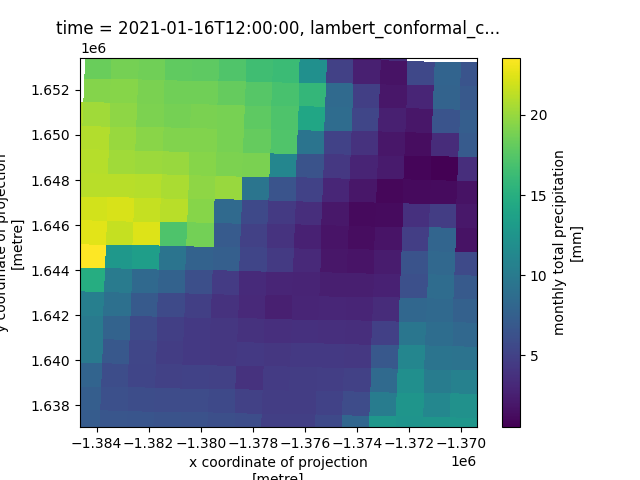

In [75]:
%matplotlib widget
daymet_multi_ds_aligned[0].plot()

### Cascade the upstream multi-dimensional precipitation downstream!

In [ ]:
%%time
ds_precip_accum = fcpgtools.accumulate_parameter(
    ds_fdr_taudem,
    daymet_multi_ds_aligned,
    engine='taudem',
    upstream_pour_points=precip_pour_point_values,
    )

In [ ]:
# verify that we updated the parameter grid
updated_coords_precip = utilities._find_downstream_cell(
    ds_fdr_taudem,
    precip_pour_point_values['pour_point_coords'][0])
us_precip_val = precip_pour_point_values['pour_point_values'][0][0]
print(f'Cascaded amount from upstream: {us_precip_val}')
ds_precip_val = utilities._query_point(
    ds_precip_accum,
    updated_coords_precip,
    )[-1]
print(f'Value of cell downstream from the upstream pour point: {ds_precip_val}')
print('If the numbers above are not very simular there is likely an issue!')

In [ ]:
%matplotlib widget
ds_precip_accum[0].plot()

### Make downstream precipitation FCPG including cascaded values from upstream

In [ ]:
%%time
ds_fcpg = fcpgtools.make_fcpg(
    ds_precip_accum,
    ds_accumulate,
    )

In [ ]:
%matplotlib widget
ds_fcpg[0].plot()